# ESC-50 Edge Audio Baseline Notebook

本Notebook按照"小步快跑"策略，用于：
1. 检查并理解ESC-50数据，确认枪声/玻璃破碎/背景样本规模。
2. 先行搭建梅尔谱特征提取与可视化helper，为后续CNN训练做准备。
3. 后面再逐步补充模型训练与评估单元。

## Imports and shared helpers
加载所有依赖与项目模块，保持 Notebook 本体只关注流程。

In [1]:
from pathlib import Path
from typing import List
import random

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

from src.config import (
    PROJECT_ROOT,
    DATA_ROOT,
    AUDIO_DIR,
    META_FILE,
    CACHE_DIR,
    POSITIVE_LABELS,
    BACKGROUND_LABEL,
    BACKGROUND_MULTIPLIER,
    WINDOW_SECONDS,
    WINDOW_HOP,
    SR,
    N_MELS,
    N_FFT,
    HOP_LENGTH,
    SEED,
)
from src.data_utils import (
    build_dataset,
    load_audio,
    log_mel_spectrogram,
    generate_aligned_windows,
)
from src.folds import assign_folds, fold_summary
from src.viz import plot_wave_and_mel
from src.cache_utils import (
    build_cache_index,
    GLASS_PIPELINE_PLAN,
    GLASS_LABELS,
    sample_background_chunk,
)
from src.augment_pipeline import PIPELINE_REGISTRY, run_pipeline

sns.set_theme(style='whitegrid')
from src.audio_qc import export_mel_to_wav, infer_base_mel_path
from IPython.display import Audio, display
from src.datasets import balance_folds, MelDataset


## 加载元数据并构建数据集
打印路径并构建玻璃/背景数据子集，这是后续流程的基准。

In [2]:
print(f'Project root: {PROJECT_ROOT}')
print(f'Metadata file: {META_FILE}')
print(f'Cache dir: {CACHE_DIR}')

meta_df = pd.read_csv(META_FILE)
dataset_df = build_dataset(meta_df)
print(f'Total selected samples: {len(dataset_df)}')
dataset_df['target_label'].value_counts().to_frame('count')

Project root: /workspace
Metadata file: /workspace/data/meta/esc50.csv
Cache dir: /workspace/cache/mel64
Total selected samples: 160


,count
target_label,
background,120
glass_breaking,40


## Fold assignment
基于 ESC-50 原生的 `fold` 字段补充 `fold_id`，方便之后做交叉验证，并输出分布。

In [3]:
dataset_df['fold_id'] = assign_folds(dataset_df)
fold_counts = fold_summary(dataset_df, fold_column='fold_id', label_column='target_label')
fold_counts

,fold_id,target_label,count
0,1,background,27
1,1,glass_breaking,8
2,2,background,23
3,2,glass_breaking,8
4,3,background,22
5,3,glass_breaking,8
6,4,background,25
7,4,glass_breaking,8
8,5,background,23
9,5,glass_breaking,8


## 可视化随机样本
抽一条记录画出波形与 log-mel，用肉眼确认数据质量。

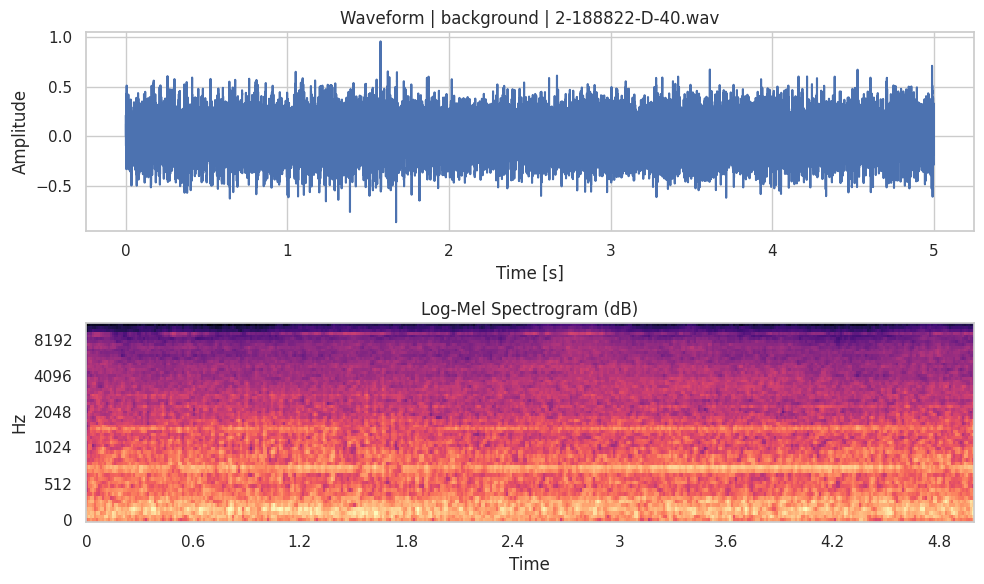

In [4]:
sample_row = dataset_df.sample(random_state=SEED).iloc[0]
plot_wave_and_mel(sample_row)

## Glass 能量分析
量化 40 条玻璃样本的 RMS 能量包络与估计持续时间，为窗口/阈值配置提供依据。

       active_duration_s  peak_time_s
count          40.000000    40.000000
mean            0.774095     0.605751
std             0.809389     1.005051
min             0.150930     0.000000
25%             0.278639     0.055147
50%             0.423764     0.139320
75%             0.856236     0.673379
max             3.076644     4.458231


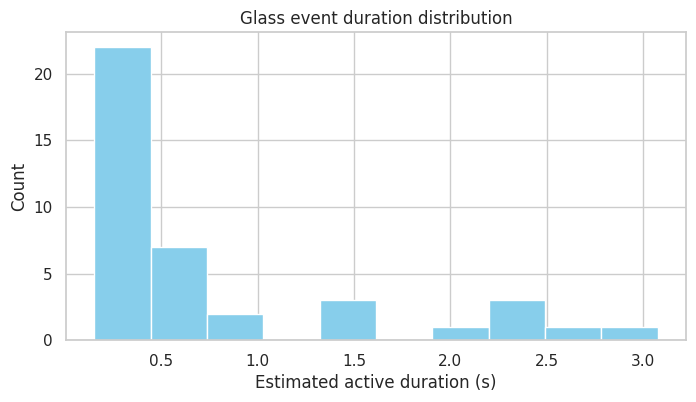

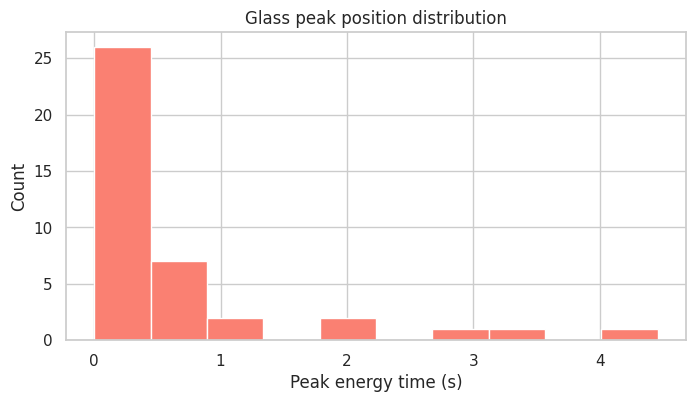

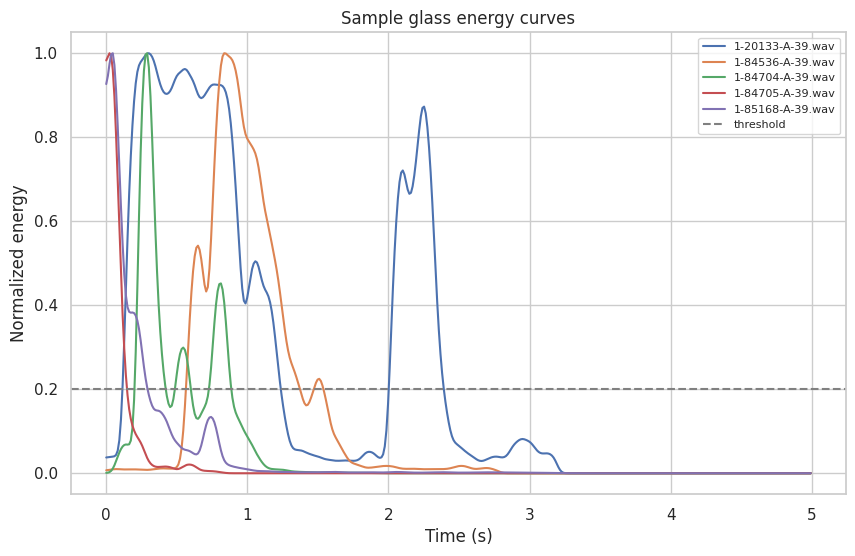

In [5]:
GLASS_TARGETS = list(GLASS_LABELS)
GLASS_ONLY = dataset_df[dataset_df['target_label'].isin(GLASS_TARGETS)].copy()

rms_records = []
energy_curves = []
frame_length = 2048
hop = 256
threshold_ratio = 0.2

for _, row in GLASS_ONLY.iterrows():
    y, sr = load_audio(row)
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop)[0]
    rms_smooth = gaussian_filter1d(rms, sigma=2)
    if rms_smooth.max() <= 0:
        continue
    energy = rms_smooth / rms_smooth.max()
    above = energy > threshold_ratio
    active_frames = above.sum()
    duration_seconds = active_frames * hop / sr
    peak_frame = int(np.argmax(energy))
    peak_time = peak_frame * hop / sr
    rms_records.append({
        'filename': row['filename'],
        'fold': row['fold_id'],
        'active_duration_s': duration_seconds,
        'peak_time_s': peak_time,
        'max_energy': rms_smooth.max(),
    })
    energy_curves.append({
        'filename': row['filename'],
        'time_axis': np.arange(len(energy)) * hop / sr,
        'energy': energy,
    })

glass_stats = pd.DataFrame(rms_records)
print(glass_stats[['active_duration_s', 'peak_time_s']].describe())

plt.figure(figsize=(8,4))
plt.hist(glass_stats['active_duration_s'], bins=10, color='skyblue')
plt.xlabel('Estimated active duration (s)')
plt.ylabel('Count')
plt.title('Glass event duration distribution')
plt.show()

plt.figure(figsize=(8,4))
plt.hist(glass_stats['peak_time_s'], bins=10, color='salmon')
plt.xlabel('Peak energy time (s)')
plt.ylabel('Count')
plt.title('Glass peak position distribution')
plt.show()

# Plot a few representative curves
plt.figure(figsize=(10,6))
for curve in energy_curves[:5]:
    plt.plot(curve['time_axis'], curve['energy'], label=curve['filename'])
plt.axhline(threshold_ratio, color='gray', linestyle='--', label='threshold')
plt.xlabel('Time (s)')
plt.ylabel('Normalized energy')
plt.title('Sample glass energy curves')
plt.legend(loc='upper right', fontsize=8)
plt.show()

### Session-specific window config
根据能量分析调整窗口/步长，覆盖参数

In [6]:
WINDOW_SECONDS = 1.0
WINDOW_HOP = 0.5
ENERGY_THRESHOLD = 0.3
PEAK_RATIO_THRESHOLD = 0.8
FRONT_PEAK_RATIO = 0.5
CACHE_EXTRA_SHIFTS = (-0.1, 0.1)
GLASS_TARGETS = list(POSITIVE_LABELS.values())
PIPELINE_PLAN = GLASS_PIPELINE_PLAN
BG_MAX_RATIO = 0.1
SNR_DB_RANGE = (3.0, 9.0)
print(f'Using WINDOW_SECONDS={WINDOW_SECONDS}, WINDOW_HOP={WINDOW_HOP}')
print(f'ENERGY_THRESHOLD={ENERGY_THRESHOLD}, PEAK_RATIO_THRESHOLD={PEAK_RATIO_THRESHOLD}, FRONT_PEAK_RATIO={FRONT_PEAK_RATIO}, BG_MAX_RATIO={BG_MAX_RATIO}, SNR_DB_RANGE={SNR_DB_RANGE}')


Using WINDOW_SECONDS=1.0, WINDOW_HOP=0.5
ENERGY_THRESHOLD=0.3, PEAK_RATIO_THRESHOLD=0.8, FRONT_PEAK_RATIO=0.5, BG_MAX_RATIO=0.1, SNR_DB_RANGE=(3.0, 9.0)


## Base window summary
统计每条玻璃 clip 经过能量筛选后保留的窗口数量与起止时间，后续方便做测试，定位有可能出现的“听起来不像玻璃”的 base。

In [7]:
base_records = []
window_len = int(WINDOW_SECONDS * SR)
hop_samples = int(WINDOW_HOP * SR)
for _, row in GLASS_ONLY.iterrows():
    y, sr = load_audio(row)
    windows = generate_aligned_windows(
        row,
        align_labels=GLASS_TARGETS,
        extra_shifts=CACHE_EXTRA_SHIFTS,
        energy_threshold=ENERGY_THRESHOLD,
        peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
        front_peak_ratio=FRONT_PEAK_RATIO,
    )
    offsets = []
    for idx_win, start in enumerate(range(0, len(y) - window_len + 1, hop_samples)):
        if idx_win >= len(windows):
            break
        offsets.append((round(start / sr, 2), round((start + window_len) / sr, 2)))
    base_records.append({
        'filename': row['filename'],
        'windows': len(windows),
        'offsets': offsets,
    })

base_summary_df = pd.DataFrame(base_records).sort_values(by='windows', ascending=False)
print('Overall glass base window stats:')
print(base_summary_df[['windows']].describe())
print(f"Total glass base windows: {int(base_summary_df['windows'].sum())}")
base_summary_df.head(10)


Overall glass base window stats:
         windows
count  40.000000
mean    1.175000
std     0.500641
min     1.000000
25%     1.000000
50%     1.000000
75%     1.000000
max     3.000000
Total glass base windows: 47


,filename,windows,offsets
30,4-204777-C-39.wav,3,"[(0.0, 1.0), (0.5, 1.5), (1.0, 2.0)]"
28,4-204777-A-39.wav,3,"[(0.0, 1.0), (0.5, 1.5), (1.0, 2.0)]"
0,1-20133-A-39.wav,2,"[(0.0, 1.0), (0.5, 1.5)]"
14,2-173618-A-39.wav,2,"[(0.0, 1.0), (0.5, 1.5)]"
10,2-112213-B-39.wav,2,"[(0.0, 1.0), (0.5, 1.5)]"
35,5-233607-A-39.wav,1,"[(0.0, 1.0)]"
34,5-233605-A-39.wav,1,"[(0.0, 1.0)]"
33,5-221529-A-39.wav,1,"[(0.0, 1.0)]"
32,5-221528-A-39.wav,1,"[(0.0, 1.0)]"
31,4-212698-A-39.wav,1,"[(0.0, 1.0)]"


## 增强管线规划
定义每个增强组合并展示 demo 输出，方便理解后续批量增强的效果与元信息。

In [8]:
PIPELINE_PLAN = GLASS_PIPELINE_PLAN
GLASS_TARGETS = list(GLASS_LABELS)


def demo_glass_augmentation(pipeline_name: str):
    glass_row = dataset_df[dataset_df['target_label'].isin(GLASS_TARGETS)].sample(random_state=SEED).iloc[0]
    base_window = generate_aligned_windows(glass_row, align_labels=GLASS_TARGETS)[0]
    background = None
    if 'mix' in PIPELINE_REGISTRY[pipeline_name]:
        background = sample_background_chunk(dataset_df, len(base_window))
    augmented = run_pipeline(base_window, pipeline_name, background=background)
    return glass_row, base_window, augmented

DEMO_PIPELINE = 'shift_mix'
demo_row, base_window, demo_augmented = demo_glass_augmentation(DEMO_PIPELINE)
metadata_stub = {
    'source_filename': demo_row['filename'],
    'fold_id': int(demo_row['fold_id']),
    'pipeline': DEMO_PIPELINE,
    'augment_desc': demo_augmented.description,
}
print(f"Demo pipeline: {demo_augmented.description}")
print(f"Base window shape: {base_window.shape}, augmented shape: {demo_augmented.audio.shape}")
metadata_stub


Demo pipeline: shift_mix(time_shift+mix)
Base window shape: (22050,), augmented shape: (22050,)


{'source_filename': '3-203375-A-39.wav',
 'fold_id': 3,
 'pipeline': 'shift_mix',
 'augment_desc': 'shift_mix(time_shift+mix)'}

## 缓存配置与抽样验证
先在极小样本上运行新缓存管线，验证峰值对齐/增强/索引输出是否符合预期。

In [9]:
SMOKE_CACHE_DIR = CACHE_DIR / 'dev_smoke'
SMOKE_CACHE_DIR.mkdir(parents=True, exist_ok=True)

smoke_df = dataset_df.groupby('target_label').head(1).copy()
smoke_cache_index = build_cache_index(
    smoke_df,
    pipeline_plan=PIPELINE_PLAN,
    cache_dir=SMOKE_CACHE_DIR,
    align_labels=GLASS_TARGETS,
    extra_shifts=CACHE_EXTRA_SHIFTS,
    energy_threshold=ENERGY_THRESHOLD,
    peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
    front_peak_ratio=FRONT_PEAK_RATIO,
    seed=SEED,
)
print(f"Smoke cache entries: {len(smoke_cache_index)}")
smoke_cache_index.head()


Smoke cache entries: 31


,path,label,fold_id,source_filename,clip_id,window_id,pipeline_name,augment_desc,source_type
0,/workspace/cache/mel64/dev_smoke/glass_breakin...,glass_breaking,1,1-20133-A-39.wav,1-20133-A-39,w00,base,base,glass_base
1,/workspace/cache/mel64/dev_smoke/glass_breakin...,glass_breaking,1,1-20133-A-39.wav,1-20133-A-39,w00,shift_gain,shift_gain(time_shift+gain),glass_aug
2,/workspace/cache/mel64/dev_smoke/glass_breakin...,glass_breaking,1,1-20133-A-39.wav,1-20133-A-39,w00,shift_gain,shift_gain(time_shift+gain),glass_aug
3,/workspace/cache/mel64/dev_smoke/glass_breakin...,glass_breaking,1,1-20133-A-39.wav,1-20133-A-39,w00,stretch_reverb,stretch_reverb(time_stretch+reverb),glass_aug
4,/workspace/cache/mel64/dev_smoke/glass_breakin...,glass_breaking,1,1-20133-A-39.wav,1-20133-A-39,w00,stretch_reverb,stretch_reverb(time_stretch+reverb),glass_aug


## 全量缓存与索引输出
在主缓存目录生成全部 mel 及索引，供训练和 QA 使用（运行时间视机器性能而定）。

In [10]:
CACHE_OUTPUT_DIR = CACHE_DIR
cache_index_df = build_cache_index(
    dataset_df,
    pipeline_plan=PIPELINE_PLAN,
    cache_dir=CACHE_OUTPUT_DIR,
    align_labels=GLASS_TARGETS,
    extra_shifts=CACHE_EXTRA_SHIFTS,
    energy_threshold=ENERGY_THRESHOLD,
    peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
    front_peak_ratio=FRONT_PEAK_RATIO,
    seed=SEED,
)
print(f"Total cached entries: {len(cache_index_df)}")
print(cache_index_df['label'].value_counts())
cache_index_df.head()


Total cached entries: 1186
label
background        669
glass_breaking    517
Name: count, dtype: int64


,path,label,fold_id,source_filename,clip_id,window_id,pipeline_name,augment_desc,source_type
0,/workspace/cache/mel64/glass_breaking/fold1/1-...,glass_breaking,1,1-20133-A-39.wav,1-20133-A-39,w00,base,base,glass_base
1,/workspace/cache/mel64/glass_breaking/fold1/1-...,glass_breaking,1,1-20133-A-39.wav,1-20133-A-39,w00,shift_gain,shift_gain(time_shift+gain),glass_aug
2,/workspace/cache/mel64/glass_breaking/fold1/1-...,glass_breaking,1,1-20133-A-39.wav,1-20133-A-39,w00,shift_gain,shift_gain(time_shift+gain),glass_aug
3,/workspace/cache/mel64/glass_breaking/fold1/1-...,glass_breaking,1,1-20133-A-39.wav,1-20133-A-39,w00,stretch_reverb,stretch_reverb(time_stretch+reverb),glass_aug
4,/workspace/cache/mel64/glass_breaking/fold1/1-...,glass_breaking,1,1-20133-A-39.wav,1-20133-A-39,w00,stretch_reverb,stretch_reverb(time_stretch+reverb),glass_aug


## Fold balancing & dataset preview
对缓存索引按 fold 做玻璃/背景配比（默认玻璃占 40%），并展示 Dataset 示例。

In [11]:
balanced_index_df = balance_folds(cache_index_df, target_ratio=0.4)
fold_counts = balanced_index_df.groupby(['fold_id', 'label']).size().reset_index(name='count')
print(f"Balanced dataset size: {len(balanced_index_df)}")
for fold_id, fold_df in fold_counts.groupby('fold_id'):
    print(f"Fold {fold_id} summary: glass={int(fold_df[fold_df['label']==GLASS_TARGETS[0]]['count'].sum())}, background={int(fold_df[fold_df['label']!='glass_breaking']['count'].sum())}")
fold_counts

mel_dataset = MelDataset(balanced_index_df)
sample_mel, sample_label = mel_dataset[0]
print(f"Sample tensor shape: {sample_mel.shape}, label: {sample_label}")


Balanced dataset size: 1166
Fold 1 summary: glass=99, background=146
Fold 2 summary: glass=110, background=130
Fold 3 summary: glass=88, background=90
Fold 4 summary: glass=132, background=151
Fold 5 summary: glass=88, background=132
Sample tensor shape: torch.Size([1, 64, 87]), label: 1


## QA 抽样列表
从索引中抽取若干增强样本，记录路径、fold、pipeline，便于后续手动试听确认音质。

In [12]:
QA_SAMPLE_COUNT = 10
qa_samples = cache_index_df[cache_index_df['label'].isin(GLASS_TARGETS)].sample(
    n=min(QA_SAMPLE_COUNT, len(cache_index_df)),
    random_state=SEED,
)
qa_samples[['path', 'fold_id', 'pipeline_name', 'augment_desc']]

,path,fold_id,pipeline_name,augment_desc
304,/workspace/cache/mel64/glass_breaking/fold4/4-...,4,filter_gain,filter_gain(filter+gain)
501,/workspace/cache/mel64/glass_breaking/fold5/5-...,5,shift_mix,shift_mix(time_shift+mix)
441,/workspace/cache/mel64/glass_breaking/fold5/5-...,5,shift_gain,shift_gain(time_shift+gain)
153,/workspace/cache/mel64/glass_breaking/fold2/2-...,2,stretch_filter,stretch_filter(time_stretch+filter)
503,/workspace/cache/mel64/glass_breaking/fold5/5-...,5,filter_gain,filter_gain(filter+gain)
131,/workspace/cache/mel64/glass_breaking/fold2/2-...,2,stretch_filter,stretch_filter(time_stretch+filter)
204,/workspace/cache/mel64/glass_breaking/fold2/2-...,2,shift_mix,shift_mix(time_shift+mix)
512,/workspace/cache/mel64/glass_breaking/fold5/5-...,5,shift_mix,shift_mix(time_shift+mix)
325,/workspace/cache/mel64/glass_breaking/fold4/4-...,4,shift_mix,shift_mix(time_shift+mix)
247,/workspace/cache/mel64/glass_breaking/fold3/3-...,3,shift_mix,shift_mix(time_shift+mix)


## QA 音频试听
将抽样列表中的部分 mel 片段还原为 wav，便于实际聆听确认增强是否合理。

In [13]:
QA_AUDIO_DIR = CACHE_OUTPUT_DIR / 'qa_audio'
QA_AUDIO_DIR.mkdir(parents=True, exist_ok=True)

qa_audio_samples = []
for _, row in qa_samples.iterrows():
    mel_path = Path(row['path'])
    base_mel_path = infer_base_mel_path(mel_path, row.get('clip_id'), row.get('window_id'))
    aug_wav = QA_AUDIO_DIR / f"{mel_path.stem}.wav"
    export_mel_to_wav(mel_path, aug_wav)
    base_wav = None
    if base_mel_path.exists():
        base_wav = QA_AUDIO_DIR / f"{base_mel_path.stem}.wav"
        export_mel_to_wav(base_mel_path, base_wav)
    qa_audio_samples.append((row, base_wav, aug_wav))

print(f"Generated {len(qa_audio_samples)} QA audio snippets at {QA_AUDIO_DIR}")
for idx, (row, base_wav, aug_wav) in enumerate(qa_audio_samples, start=1):
    header = (
        f"=== Sample {idx} | Label: {row['label']} | Fold: {row['fold_id']} "
        f"| Pipeline: {row['pipeline_name']} ==="
    )
    print(header)
    print(f"Description: {row['augment_desc']}")
    if base_wav:
        print('[BASE]')
        display(Audio(filename=base_wav, rate=SR))
        print(f"File: {base_wav}")
    else:
        print('[BASE] Not available for this sample.')
    print('[AUG]')
    display(Audio(filename=aug_wav, rate=SR))
    print(f"File: {aug_wav}")


Generated 10 QA audio snippets at /workspace/cache/mel64/qa_audio
=== Sample 1 | Label: glass_breaking | Fold: 4 | Pipeline: filter_gain ===
Description: filter_gain(filter+gain)
[BASE]


File: /workspace/cache/mel64/qa_audio/4-204115-A-39_base_w00.wav
[AUG]


File: /workspace/cache/mel64/qa_audio/4-204115-A-39_filter_gain_w00_c00.wav
=== Sample 2 | Label: glass_breaking | Fold: 5 | Pipeline: shift_mix ===
Description: shift_mix(time_shift+mix)
[BASE]


File: /workspace/cache/mel64/qa_audio/5-260433-A-39_base_w00.wav
[AUG]


File: /workspace/cache/mel64/qa_audio/5-260433-A-39_shift_mix_w00_c01.wav
=== Sample 3 | Label: glass_breaking | Fold: 5 | Pipeline: shift_gain ===
Description: shift_gain(time_shift+gain)
[BASE]


File: /workspace/cache/mel64/qa_audio/5-221529-A-39_base_w00.wav
[AUG]


File: /workspace/cache/mel64/qa_audio/5-221529-A-39_shift_gain_w00_c00.wav
=== Sample 4 | Label: glass_breaking | Fold: 2 | Pipeline: stretch_filter ===
Description: stretch_filter(time_stretch+filter)
[BASE]


File: /workspace/cache/mel64/qa_audio/2-141563-A-39_base_w00.wav
[AUG]


File: /workspace/cache/mel64/qa_audio/2-141563-A-39_stretch_filter_w00_c00.wav
=== Sample 5 | Label: glass_breaking | Fold: 5 | Pipeline: filter_gain ===
Description: filter_gain(filter+gain)
[BASE]


File: /workspace/cache/mel64/qa_audio/5-260433-A-39_base_w00.wav
[AUG]


File: /workspace/cache/mel64/qa_audio/5-260433-A-39_filter_gain_w00_c01.wav
=== Sample 6 | Label: glass_breaking | Fold: 2 | Pipeline: stretch_filter ===
Description: stretch_filter(time_stretch+filter)
[BASE]


File: /workspace/cache/mel64/qa_audio/2-112213-B-39_base_w00.wav
[AUG]


File: /workspace/cache/mel64/qa_audio/2-112213-B-39_stretch_filter_w00_c00.wav
=== Sample 7 | Label: glass_breaking | Fold: 2 | Pipeline: shift_mix ===
Description: shift_mix(time_shift+mix)
[BASE]


File: /workspace/cache/mel64/qa_audio/2-250710-A-39_base_w00.wav
[AUG]


File: /workspace/cache/mel64/qa_audio/2-250710-A-39_shift_mix_w00_c01.wav
=== Sample 8 | Label: glass_breaking | Fold: 5 | Pipeline: shift_mix ===
Description: shift_mix(time_shift+mix)
[BASE]


File: /workspace/cache/mel64/qa_audio/5-260434-A-39_base_w00.wav
[AUG]


File: /workspace/cache/mel64/qa_audio/5-260434-A-39_shift_mix_w00_c01.wav
=== Sample 9 | Label: glass_breaking | Fold: 4 | Pipeline: shift_mix ===
Description: shift_mix(time_shift+mix)
[BASE]


File: /workspace/cache/mel64/qa_audio/4-204121-A-39_base_w00.wav
[AUG]


File: /workspace/cache/mel64/qa_audio/4-204121-A-39_shift_mix_w00_c01.wav
=== Sample 10 | Label: glass_breaking | Fold: 3 | Pipeline: shift_mix ===
Description: shift_mix(time_shift+mix)
[BASE]


File: /workspace/cache/mel64/qa_audio/3-203375-A-39_base_w00.wav
[AUG]


File: /workspace/cache/mel64/qa_audio/3-203375-A-39_shift_mix_w00_c00.wav


## Background QA samples
随机挑选部分背景切片试听，确认负样本质量。

In [14]:
bg_samples = cache_index_df[cache_index_df['label'] != GLASS_TARGETS[0]].sample(n=min(5, len(cache_index_df)), random_state=SEED)
BG_QA_DIR = CACHE_OUTPUT_DIR / 'qa_audio' / 'background'
BG_QA_DIR.mkdir(parents=True, exist_ok=True)

for idx, row in bg_samples.iterrows():
    mel_path = Path(row['path'])
    wav_path = BG_QA_DIR / f"{mel_path.stem}.wav"
    export_mel_to_wav(mel_path, wav_path)
    print(f"Background sample | Fold {row['fold_id']} | Source: {row['source_filename']} | Type: {row.get('source_type','unknown')}")
    display(Audio(filename=wav_path, rate=SR))


Background sample | Fold 1 | Source: 1-96890-A-37.wav | Type: background_raw


Background sample | Fold 2 | Source: 2-82367-A-10.wav | Type: background_raw


Background sample | Fold 1 | Source: 1-79711-A-32.wav | Type: background_raw


Background sample | Fold 3 | Source: 3-118194-A-33.wav | Type: background_raw


Background sample | Fold 5 | Source: 5-238938-A-27.wav | Type: background_raw


## Output Data Index
导出一个可复用的索引，在训练notebook中引用

In [15]:
# balanced_index_df.to_parquet("cache/index_balanced.parquet", index=False)
balanced_index_df.to_csv("cache/index_balanced.csv", index=False)